In [1]:
import os
os.chdir("../")
import numpy as np

## Data Visualisation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
file_path = "data/glyph/"
sans_df = np.load(file_path + 'aug_sans_serif.pkl', allow_pickle=True)
test_sans_df = np.load(file_path + 'test_sans_serif.pkl', allow_pickle=True)

serif_df = np.load(file_path + 'aug_serif.pkl', allow_pickle=True)
test_serif_df = np.load(file_path + 'test_serif.pkl', allow_pickle=True)

In [4]:
total_sans = pd.concat([sans_df, test_sans_df])
total_serif = pd.concat([serif_df, test_serif_df])

[Text(0.5, 1.0, 'Serif')]

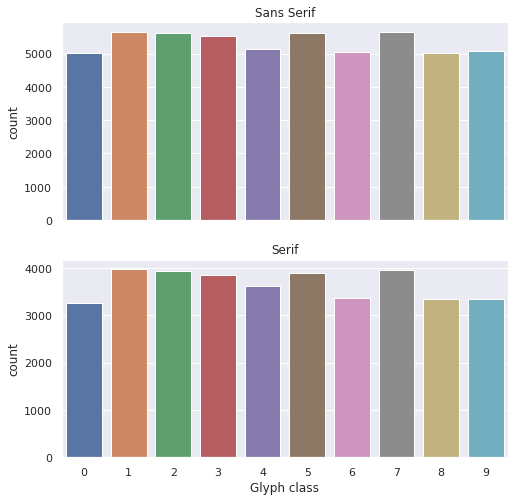

In [5]:
import seaborn as sns
sns.set_theme(style="darkgrid")

fig, axs = plt.subplots(2, 1, figsize=(8, 8))

total_sans = total_sans.rename(columns={'value':'Glyph class'})
sans_plt = sns.countplot(x='Glyph class', data=total_sans, ax=axs[0])
sans_plt.set(title='Sans Serif')
sans_plt.set(xticklabels=[])
sans_plt.set(xlabel=None)

total_serif = total_serif.rename(columns={'value':'Glyph class'})
serif_plt = sns.countplot(x='Glyph class', data=total_serif, ax=axs[1])
serif_plt.set(title='Serif')

In [6]:
import torch
from torch.utils.data import DataLoader
from data.transform import ToFixedTensor

from utils.metric import Metrics
from data.torch_dataset import GlyphGeom
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
@torch.no_grad()
def validation(loader, model, criterion):
    metr = Metrics(10)
    model.eval()
    for idx, data in enumerate(loader):
        x = data['geom'].to(torch.device(device), dtype=torch.float)
        y = data['value'].to(torch.device(device))

        logits = model(x)
        loss = criterion(logits, y)

        metr.update_cm(logits, y)
        metr.update_loss(loss)
    
    print(f"Avg Valid Loss: {metr.avg_loss():.4f} \n"
          f"Overall Valid Acc: {metr.accuracy():.4f} \n"
          f"{'-' * 80}") 
    return metr, metr.avg_loss()

In [8]:
from model.net import CNN, Deepset, GCNN, SetTransformer

def build_model(nn, checkpoint_name=None):
    if nn == 'cnn':
        model = CNN(3, 10)
    elif nn == 'deepset':
        model = Deepset(3, 10, 2048)
    elif nn == 'gcnn':
        model = GCNN(3, 10, 2048)
    elif nn == 'transformer':
        model = SetTransformer(3, 10, 512)
    
    checkpoint=torch.load('saved/'+f'{checkpoint_name}.pth')
    model.load_state_dict(checkpoint['model_state'])

    model.to(torch.device(device))
    criterion = torch.nn.CrossEntropyLoss()
    
    return model, criterion

## Glyph Geometry

In [9]:
serif_o = test_serif_df[test_serif_df['type']=='o']
serif_r = test_serif_df[test_serif_df['type']=='r']
serif_s = test_serif_df[test_serif_df['type']=='s']
serif_d = test_serif_df[test_serif_df['type']=='d']

sans_o = test_sans_df[test_sans_df['type']=='o']
sans_r = test_sans_df[test_sans_df['type']=='r']
sans_s = test_sans_df[test_sans_df['type']=='s']
sans_d = test_sans_df[test_sans_df['type']=='d']

In [10]:
test_serif_o = GlyphGeom(data_dir=file_path, dataframe=serif_o, transform=ToFixedTensor(1500))
test_serif_r = GlyphGeom(data_dir=file_path, dataframe=serif_r, transform=ToFixedTensor(1500))
test_serif_s = GlyphGeom(data_dir=file_path, dataframe=serif_s, transform=ToFixedTensor(1500))
test_serif_d = GlyphGeom(data_dir=file_path, dataframe=serif_d, transform=ToFixedTensor(1500))

test_sans_o = GlyphGeom(data_dir=file_path, dataframe=sans_o, transform=ToFixedTensor(1500))
test_sans_r = GlyphGeom(data_dir=file_path, dataframe=sans_r, transform=ToFixedTensor(1500))
test_sans_s = GlyphGeom(data_dir=file_path, dataframe=sans_s, transform=ToFixedTensor(1500))
test_sans_d = GlyphGeom(data_dir=file_path, dataframe=sans_d, transform=ToFixedTensor(1500))

In [11]:
# Original
test_loader = DataLoader(test_serif_o, batch_size=64, shuffle=True)

# CNN
model, criterion = build_model('cnn', 'cnn/sans_serif')
metr_cnn_o, _ = validation(test_loader, model, criterion)

# Deepset
model, criterion = build_model('deepset', 'deepset/sans_serif')
metr_deepset_o, _ = validation(test_loader, model, criterion)

# GCNN
model, criterion = build_model('gcnn', 'gcnn/sans_serif')
metr_gcnn_o, _ = validation(test_loader, model, criterion)

# SetTransformer
model, criterion = build_model('transformer', 'transformer/sans_serif')
metr_setTr_o, _ = validation(test_loader, model, criterion)

Avg Valid Loss: 0.5721 
Overall Valid Acc: 0.8514 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.1580 
Overall Valid Acc: 0.9530 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.1434 
Overall Valid Acc: 0.9525 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.3336 
Overall Valid Acc: 0.9110 
--------------------------------------------------------------------------------


In [12]:
# Rotation
test_loader = DataLoader(test_serif_r, batch_size=64, shuffle=True)

# CNN
model, criterion = build_model('cnn', 'cnn/sans_serif')
metr_cnn_r, _ = validation(test_loader, model, criterion)

# Deepset
model, criterion = build_model('deepset', 'deepset/sans_serif')
metr_deepset_r, _ = validation(test_loader, model, criterion)

# GCNN
model, criterion = build_model('gcnn', 'gcnn/sans_serif')
metr_gcnn_r, _ = validation(test_loader, model, criterion)

# SetTransformer
model, criterion = build_model('transformer', 'transformer/sans_serif')
metr_setTr_r, _ = validation(test_loader, model, criterion)

Avg Valid Loss: 0.8232 
Overall Valid Acc: 0.7974 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.3502 
Overall Valid Acc: 0.9061 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.2912 
Overall Valid Acc: 0.9072 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.7264 
Overall Valid Acc: 0.7930 
--------------------------------------------------------------------------------


In [13]:
# Scale
test_loader = DataLoader(test_serif_s, batch_size=64, shuffle=True)

# CNN
model, criterion = build_model('cnn', 'cnn/sans_serif')
metr_cnn_s, _ = validation(test_loader, model, criterion)

# Deepset
model, criterion = build_model('deepset', 'deepset/sans_serif')
metr_deepset_s, _ = validation(test_loader, model, criterion)

# GCNN
model, criterion = build_model('gcnn', 'gcnn/sans_serif')
metr_gcnn_s, _ = validation(test_loader, model, criterion)

# SetTransformer
model, criterion = build_model('transformer', 'transformer/sans_serif')
metr_setTr_s, _ = validation(test_loader, model, criterion)

Avg Valid Loss: 0.8282 
Overall Valid Acc: 0.7870 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.5224 
Overall Valid Acc: 0.8367 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.3088 
Overall Valid Acc: 0.8990 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.7984 
Overall Valid Acc: 0.7602 
--------------------------------------------------------------------------------


In [14]:
# Skew
test_loader = DataLoader(test_serif_d, batch_size=64, shuffle=True)

# CNN
model, criterion = build_model('cnn', 'cnn/sans_serif')
metr_cnn_d, _ = validation(test_loader, model, criterion)

# Deepset
model, criterion = build_model('deepset', 'deepset/sans_serif')
metr_deepset_d, _ = validation(test_loader, model, criterion)

# GCNN
model, criterion = build_model('gcnn', 'gcnn/sans_serif')
metr_gcnn_d, _ = validation(test_loader, model, criterion)

# SetTransformer
model, criterion = build_model('transformer', 'transformer/sans_serif')
metr_setTr_d, _ = validation(test_loader, model, criterion)

Avg Valid Loss: 0.7448 
Overall Valid Acc: 0.8105 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.3839 
Overall Valid Acc: 0.8777 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.2798 
Overall Valid Acc: 0.9137 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.6974 
Overall Valid Acc: 0.7946 
--------------------------------------------------------------------------------


In [15]:
acc = {
       'Original': {'CNN':metr_cnn_o.accuracy().item() * 100, 
                    'DeepSet':metr_deepset_o.accuracy().item() * 100, 
                    'GCNN':metr_gcnn_o.accuracy().item() * 100, 
                    'Set Transformer':metr_setTr_o.accuracy().item() * 100},
       
       'Rotation': {'CNN':metr_cnn_r.accuracy().item() * 100, 
                    'DeepSet':metr_deepset_r.accuracy().item() * 100, 
                    'GCNN':metr_gcnn_r.accuracy().item() * 100, 
                    'Set Transformer':metr_setTr_r.accuracy().item() * 100}, 
       
       'Skew': {'CNN':metr_cnn_d.accuracy().item() * 100, 
                'DeepSet':metr_deepset_d.accuracy().item() * 100, 
                'GCNN':metr_gcnn_d.accuracy().item() * 100, 
                'Set Transformer':metr_setTr_d.accuracy().item() * 100}, 
       
       'Scale': {'CNN':metr_cnn_s.accuracy().item() * 100, 
                 'DeepSet':metr_deepset_s.accuracy().item() * 100, 
                 'GCNN':metr_gcnn_s.accuracy().item() * 100, 
                 'Set Transformer':metr_setTr_s.accuracy().item() * 100}
       }
serif_acc_df = pd.DataFrame.from_dict(acc)

In [16]:
# Original
test_loader = DataLoader(test_sans_o, batch_size=64, shuffle=True)

# CNN
model, criterion = build_model('cnn', 'cnn/serif')
metr_cnn_o, _ = validation(test_loader, model, criterion)

# Deepset
model, criterion = build_model('deepset', 'deepset/serif')
metr_deepset_o, _ = validation(test_loader, model, criterion)

# GCNN
model, criterion = build_model('gcnn', 'gcnn/serif')
metr_gcnn_o, _ = validation(test_loader, model, criterion)

# SetTransformer
model, criterion = build_model('transformer', 'transformer/serif')
metr_setTr_o, _ = validation(test_loader, model, criterion)

Avg Valid Loss: 0.3723 
Overall Valid Acc: 0.8987 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.2110 
Overall Valid Acc: 0.9512 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.0918 
Overall Valid Acc: 0.9690 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.2732 
Overall Valid Acc: 0.9138 
--------------------------------------------------------------------------------


In [17]:
# Rotation
test_loader = DataLoader(test_sans_r, batch_size=64, shuffle=True)

# CNN
model, criterion = build_model('cnn', 'cnn/serif')
metr_cnn_r, _ = validation(test_loader, model, criterion)

# Deepset
model, criterion = build_model('deepset', 'deepset/serif')
metr_deepset_r, _ = validation(test_loader, model, criterion)

# GCNN
model, criterion = build_model('gcnn', 'gcnn/serif')
metr_gcnn_r, _ = validation(test_loader, model, criterion)

# SetTransformer
model, criterion = build_model('transformer', 'transformer/serif')
metr_setTr_r, _ = validation(test_loader, model, criterion)

Avg Valid Loss: 0.4975 
Overall Valid Acc: 0.8586 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.3555 
Overall Valid Acc: 0.9040 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.2027 
Overall Valid Acc: 0.9414 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.4441 
Overall Valid Acc: 0.8631 
--------------------------------------------------------------------------------


In [18]:
# Scale
test_loader = DataLoader(test_sans_s, batch_size=64, shuffle=True)

# CNN
model, criterion = build_model('cnn', 'cnn/serif')
metr_cnn_s, _ = validation(test_loader, model, criterion)

# Deepset
model, criterion = build_model('deepset', 'deepset/serif')
metr_deepset_s, _ = validation(test_loader, model, criterion)

# GCNN
model, criterion = build_model('gcnn', 'gcnn/serif')
metr_gcnn_s, _ = validation(test_loader, model, criterion)

# SetTransformer
model, criterion = build_model('transformer', 'transformer/serif')
metr_setTr_s, _ = validation(test_loader, model, criterion)

Avg Valid Loss: 0.6231 
Overall Valid Acc: 0.8261 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.5590 
Overall Valid Acc: 0.8450 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.2468 
Overall Valid Acc: 0.9297 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.6264 
Overall Valid Acc: 0.8015 
--------------------------------------------------------------------------------


In [19]:
# Skew
test_loader = DataLoader(test_sans_d, batch_size=64, shuffle=True)

# CNN
model, criterion = build_model('cnn', 'cnn/serif')
metr_cnn_d, _ = validation(test_loader, model, criterion)

# Deepset
model, criterion = build_model('deepset', 'deepset/serif')
metr_deepset_d, _ = validation(test_loader, model, criterion)

# GCNN
model, criterion = build_model('gcnn', 'gcnn/serif')
metr_gcnn_d, _ = validation(test_loader, model, criterion)

# SetTransformer
model, criterion = build_model('transformer', 'transformer/serif')
metr_setTr_d, _ = validation(test_loader, model, criterion)

Avg Valid Loss: 0.5036 
Overall Valid Acc: 0.8544 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.4701 
Overall Valid Acc: 0.8609 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.2411 
Overall Valid Acc: 0.9285 
--------------------------------------------------------------------------------
Avg Valid Loss: 0.5095 
Overall Valid Acc: 0.8476 
--------------------------------------------------------------------------------


In [20]:
acc = {
       'Original': {'CNN':metr_cnn_o.accuracy().item() * 100, 
                    'DeepSet':metr_deepset_o.accuracy().item() * 100, 
                    'GCNN':metr_gcnn_o.accuracy().item() * 100, 
                    'Set Transformer':metr_setTr_o.accuracy().item() * 100},
       
       'Rotation': {'CNN':metr_cnn_r.accuracy().item() * 100, 
                    'DeepSet':metr_deepset_r.accuracy().item() * 100, 
                    'GCNN':metr_gcnn_r.accuracy().item() * 100, 
                    'Set Transformer':metr_setTr_r.accuracy().item() * 100}, 
       
       'Skew': {'CNN':metr_cnn_d.accuracy().item() * 100, 
                'DeepSet':metr_deepset_d.accuracy().item() * 100, 
                'GCNN':metr_gcnn_d.accuracy().item() * 100, 
                'Set Transformer':metr_setTr_d.accuracy().item() * 100}, 
       
       'Scale': {'CNN':metr_cnn_s.accuracy().item() * 100, 
                 'DeepSet':metr_deepset_s.accuracy().item() * 100, 
                 'GCNN':metr_gcnn_s.accuracy().item() * 100, 
                 'Set Transformer':metr_setTr_s.accuracy().item() * 100}
       }
sans_acc_df = pd.DataFrame.from_dict(acc)

[Text(0, 0.5, 'Accuracy(%)')]

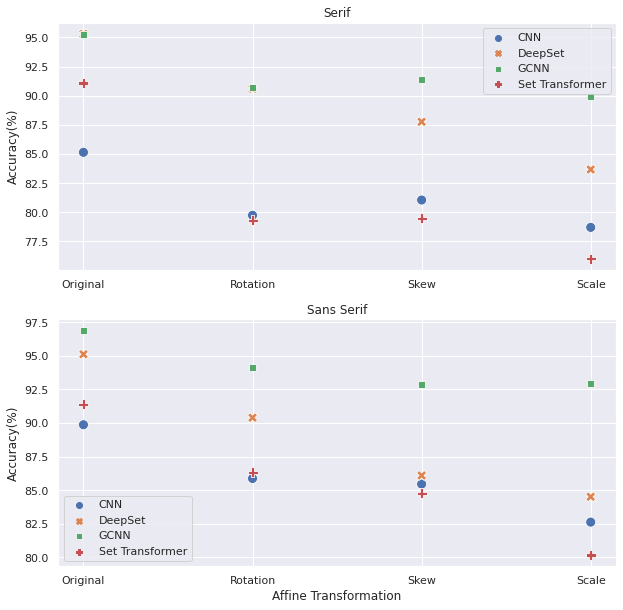

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

serif_acc_plt = sns.scatterplot(data=serif_acc_df.T, s=100, ax=axs[0])
serif_acc_plt.set(title='Serif')
serif_acc_plt.set(xlabel=None)
serif_acc_plt.set(ylabel='Accuracy(%)')

sans_acc_plt = sns.scatterplot(data=sans_acc_df.T, s=100, ax=axs[1])
sans_acc_plt.set(title='Sans Serif')
sans_acc_plt.set(xlabel='Affine Transformation')
sans_acc_plt.set(ylabel='Accuracy(%)')